In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import IPython.display
import pandas as pd
from sklearn.model_selection import train_test_split
import gc
from matplotlib import gridspec

In [2]:
# Read data and getting full file path
df = pd.read_csv('../data.csv')
filesDir = '../Database/'
df['File'] = df.File.str[-16:]
df['File'] = filesDir + df['File']
df = df.rename(columns={'Time_duration (mm:ss)': 'Time_duration','Time_start (mm:ss.ms)':'Time_start'})
#print(df.head(5))

In [3]:
filename = df['File'][0] 
start = df['Time_start'][0]
duration = df['Time_duration'][0]


In [4]:
# support functions
def getVideoResolution(filename):
    import re
    import subprocess as sp
    command_info = ['ffprobe', '-show_streams',
            '-i', filename]
    pipe = sp.Popen(command_info, stdout=sp.PIPE,stderr=sp.STDOUT)
    for x in pipe.stdout.readlines():
        if (re.findall('\\bwidth\\b', x.decode())):
            W = re.findall(r'\d+', x.decode())[0]
        if (re.findall('\\bheight\\b', x.decode())):
            H = re.findall(r'\d+', x.decode())[0]
    pipe.kill()        
    return (int(H),int(W))   

def getFrameRate(filename):
    import re
    import subprocess as sp
    command_info = ['ffprobe', '-show_streams',
            '-i', filename]
    pipe = sp.Popen(command_info, stdout=sp.PIPE,stderr=sp.STDOUT)

    fr = None
    for x in pipe.stdout.readlines():
        if (re.findall('\\bavg_frame_rate\\b', x.decode())):
            fr = re.findall(r'\d+', x.decode())
            fr = (float(fr[0])/float(fr[1]))
            pipe.kill()
            return fr
    pipe.kill()    
    return (fr)   

def getSampleRate(filename):
    import re
    import subprocess as sp
    command_info = ['ffprobe', '-show_streams',
            '-i', filename]
    pipe = sp.Popen(command_info, stdout=sp.PIPE,stderr=sp.STDOUT)

    for x in pipe.stdout.readlines():
        if (re.findall('\\bsample_rate\\b', x.decode())):
            sr = re.findall(r'\d+', x.decode())[0]
            pipe.kill()
            return int(sr)
    pipe.kill()    
    return (0)   

def getAudioCodecName(filename):
    import re
    import subprocess as sp
    command_info = ['ffprobe', '-show_streams',
            '-i', filename]
    pipe = sp.Popen(command_info, stdout=sp.PIPE,stderr=sp.STDOUT)
    index = 0
    for x in pipe.stdout.readlines():
        if (re.findall('\\bindex=1\\b', x.decode())):
            index=1
        if (index == 1):    
            if (re.findall('\\bcodec_name\\b', x.decode())):
                sr = re.findall(r'=(\w+)', x.decode())[0]
                pipe.kill()
                return sr
    pipe.kill()    
    return (0)  

def timeStringToFloat(timestr, timeFormat=[3600,60,1]):
    return sum([a*b for a,b in zip(timeFormat, map(float,timestr.split(':')))])
      

In [5]:
# Read videos
def readFrames(filename, duration, start="00:00:00", framedrop=1, fd=None):
    import platform
    import subprocess as sp
    import numpy as np
    
    OS =  platform.system()
    if (OS == "Linux"):
        FFMPEG_BIN = "ffmpeg"
    elif (OS == "Windows"):
        FFMPEG_BIN = "ffmpeg.exe"
    else:
        raise Exception("OS not identified")   
    
    H,W = getVideoResolution(filename)    
    fr = getFrameRate(filename)
    nframes = int(fr * timeStringToFloat(duration,timeFormat=[60,1]))
    if fd == None:
        fd = [H,W]
    
    command = [ FFMPEG_BIN,
            '-ss', start, 
            '-i', filename,
            '-t', duration,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
    pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)
    
    frameList=[]
    for f in range(nframes):
        raw_image = pipe.stdout.read(H * W * 3)
        image =  np.fromstring(raw_image, dtype=np.uint8)
        if (image.size != 0):
            if (f%framedrop==0):
                image = image.reshape((H,W,3))
                image = image[H//2-fd[0]//2:H//2+fd[0]//2, W//2-fd[1]//2:W//2+fd[1]//2,:]
                frameList.append(image)
    pipe.kill()            
    return frameList

In [6]:
# Read audio
def readAudio(filename, duration, start="00:00:00", mono=False, normRange=None):
    import numpy as np
    import platform
    import subprocess as sp
    
    OS =  platform.system()
    if (OS == "Linux"):
        FFMPEG_BIN = "ffmpeg"
    elif (OS == "Windows"):
        FFMPEG_BIN = "ffmpeg.exe"
    else:
        raise Exception("OS not identified")
    
    audioCodec = getAudioCodecName(filename)
    
    if mono:
        numberChannels = 1
    else:
        numberChannels = 2
        
    sr = getSampleRate(filename)
    
    command = [ FFMPEG_BIN,
            '-ss', start,   
            '-i', filename,
            '-t', duration,
            '-f', 's16le',
            '-acodec', 'pcm_s16le',
            '-ar', str(sr),
            '-ac', str(numberChannels), 
            '-']
    pipe = sp.Popen(command, stdout=sp.PIPE, bufsize=10**8)
    raw_audio = pipe.stdout.read(int(numberChannels*sr*timeStringToFloat(duration)))
    audio_array = np.fromstring(raw_audio, dtype="int16")
    if mono==False:
        audio_array = audio_array.reshape((len(audio_array)//2,2))
    pipe.kill()
    if normRange != None:
        audio_array = (audio_array).astype(np.float32)        
        return (normRange[1]-normRange[0])*(audio_array - audio_array.min())/(audio_array.max()-audio_array.min())+normRange[0]
    else:    
        return audio_array      

In [7]:
#Audio manipulation
def splitSignal(audio,chuckSize,overlapping=0):
    ss = []
    for i in range(0,len(audio),chuckSize-overlapping):
        ss.append(audio[i:i+chuckSize])
    return ss

def createAudioFrames(audio, sr, fr):
    return splitSignal(audio, int(sr//fr))

def displayAudioFrames(audio_frames, sr):
    for af in audio_frames:
        IPython.display.display(IPython.display.Audio(data=af, rate=sr) )
        
def groupedFrames(frames, csize):
    return list(zip(*[iter(video_frames_frames)]*csize))
    
def mergeAudioFrames(audio_frames, n):
    af = []
    for i in range(0, len(audio_frames), n):
        af.append(np.concatenate(audio_frames[i:i+n]))
    return af 

def mergeSignal(audio_list,chuckSize=0,overlapping=0):
    y = np.hstack(audio_list)
    remove=[]
    for i in range(overlapping):
        remove = remove + list(np.arange(chuckSize+i,y.size,chuckSize))
    return np.delete(y,remove)

def removeDC(audio):
    return audio-audio.mean()


In [232]:
#Audio plot functions
def plotAudio(audio,sr=None,title=None,Yrange=None):
    import matplotlib.pyplot as plt
    if sr == None:
        t = np.arange(0,len(audio),1)
    else:
        t = np.arange(0,len(audio),1)/sr
    plt.figure()
    plt.plot(t,audio)
    if title:
        plt.title(title)
    if Yrange:
        plt.ylim(Yrange)
    
    plt.show()
    
def plotAudioFrames(audio_frames, sr):
    import matplotlib.pyplot as plt
    prev = 0
    for i,a in enumerate(audio_frames):
        t = (np.arange(0,audio_frames[i].size,1) + prev)/sr 
        fig, (ax1) = plt.subplots(1,1)
        ax1.plot(t,a)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        plt.show()
        
def plotVideoAndAudioFrames(audio_frames,video_frames, sr):
    prev = 0
    for i ,(a, v) in enumerate (list(zip(audio_frames,video_frames))):
        t = (np.arange(0,audio_frames[i].size,1) + prev)/sr 
        np.set_printoptions(precision=6)
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
        ax1.imshow(v,aspect='auto')
        ax2.plot(t,a)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Amplitude')
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right')
        fig.tight_layout()
        plt.show()
        prev = prev + audio_frames[i].size        
        

In [263]:
# Audio features
def zero_crossing(audio):
    import numpy as np
    return len(np.where(np.diff(np.sign(audio)))[0])

def voicedTime(signal, t, hold = 0):
    totalSamples = signal.size
    segments = findVoicedSemants(abs(signal),t,hold)
    numVoicedSamples = 0
    print(len(segments))
    for seg in segments:
        numVoicedSamples += seg[1]-seg[0]
    
    return (numVoicedSamples/totalSamples , abs((numVoicedSamples)/totalSamples-1))

def totalEnergy(signal):
    return (signal**2).sum()

print(voicedTime(A,0.012,10000))

13
(0.6081147959183674, 0.39188520408163263)


In [221]:
# Audio Pre-processing
def normalize(array, normRange=[0,1]):
    return ( (normRange[1]-normRange[0]) *
            (array - array.min())/(array.max()-array.min())+normRange[0] )

def energyEnvelop(signal, window):
    import numpy as np
    signal = splitSignal(signal,window)
    output = np.zeros(len(signal))
    for i, subsingal in enumerate(signal):
        output[i]=  np.sqrt(np.mean(subsingal**2)) 
    return output

def STFT (signal, frameSize):
    import numpy as np
    output = np.zeros(len(signal),np.complex) 
    for i in range (0,len(signal),frameSize):
        output[i:i+frameSize] = np.fft.fft(signal[i:i+frameSize])
    return output

def MelFrequency(f):
    fc = 1000
    if f < 1000:
        return M
    else:
        return fc * (1 + np.log(f/fc) ) 

def energy(signal):
    return signal**2

def findVoicedSemants(signal, t, hold = 0):
    tVal = signal.max() * t
    signVariationArray = np.diff(np.sign(signal - tVal))
    (signVariationIdx,) = np.nonzero(signVariationArray)
    signVariationIdx = signVariationIdx.astype(float)
    
    signVariationIdx = np.insert(signVariationIdx,-1,float('inf'))
    signVariationIdx[-2:] = signVariationIdx[-1],signVariationIdx[-2]
    
    shiftIdx = np.zeros_like(signVariationIdx)
    shiftIdx[0] = float('-inf')
    shiftIdx[1:] = signVariationIdx[:-1]
    
    endSegments = shiftIdx[(abs(shiftIdx  - signVariationIdx)>hold)][1:]
    startSegments = signVariationIdx[(abs(shiftIdx  - signVariationIdx)>hold)][:-1]
    
    segments = []
    for i in range(0,len(startSegments)):
        segments.append((int(startSegments[i]),int(endSegments[i])))
    return segments

In [136]:
A = readAudio(filename,duration,start,mono=True)
A = normalize(A,normRange=[-1,1])
A = removeDC(A)

[(32002, 80804), (117478, 179979), (225970, 265338), (305909, 328455), (339613, 368716), (406008, 440990), (492606, 566740), (606516, 637983), (648773, 702288), (734316, 779141), (818104, 962211), (992875, 1047524), (1079805, 1154949)]
13


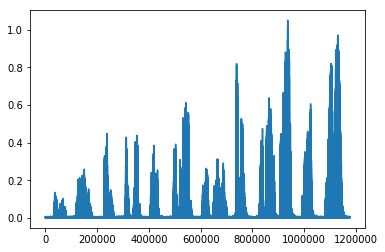

In [260]:
t = 0.012
l = 10000
test =np.sqrt(EA)
s = findVoicedSemants(abs(A),t,l)
print(s)
print(len(s))
plotAudio(test)
IPython.display.display(IPython.display.Audio(A, rate=48000))
for p in s:
    IPython.display.display(IPython.display.Audio(A[p[0]:p[1]], rate=48000))
    #seg = np.zeros_like(test)
    #seg[p[0]:p[1]] = test[p[0]:p[1]]
    #plotAudio(seg,Yrange=[0,1])

In [242]:
IPython.display.display(IPython.display.Audio(A, rate=48000))
IPython.display.display(IPython.display.Audio(A[32761:80299], rate=48000))
IPython.display.display(IPython.display.Audio(A[117627:179958], rate=48000))
IPython.display.display(IPython.display.Audio(A[225978:265026], rate=48000))


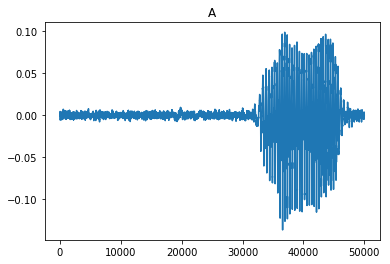

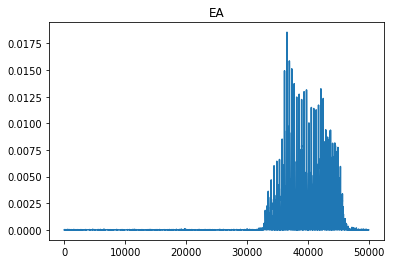

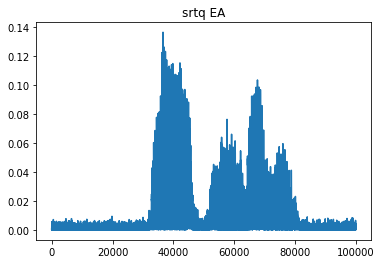

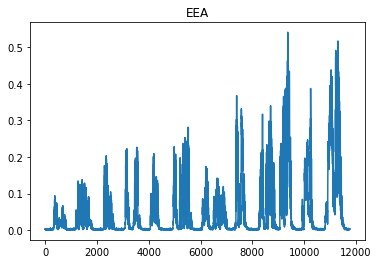

In [142]:
EEA = energyEnvelop(A,100)
EA = energy(A)
plotAudio(A[:50000],title='A')
plotAudio(EA[:50000],title='EA')
plotAudio(np.sqrt(EA)[:100000],title='srtq EA')
plotAudio(EEA[:50000],title='EEA')
#EA2 = EA.copy()
#EA2[EA2<0.01]=0
#plotAudio(EA2[300:850])

[]


In [ ]:
def saveAudio(audio_array, output_filename):
    import numpy as np
    import platform
    import subprocess as sp
    #print(filename)
    command = ['ffmpeg',
           '-y', # (optional) means overwrite the output file if it already exists.
           '-f', 's16le', # means 16bit input
           '-acodec', 'pcm_s16le', # means raw 16bit input
           '-ar', '48000', # the input will have 44100 Hz
           '-ac','1', # the input will have 2 channels (stereo)
           '-i', '-', # means that the input will arrive from the pipe
           '-vn', # means "don't expect any video input"
           '-acodec', 'copy', # output audio codec
           '-b:a', '1536k', # output bitrate (=quality). Here, 3000kb/second  
           output_filename]

    pipe = sp.Popen(command, stdin=sp.PIPE,stdout=sp.PIPE, stderr=sp.STDOUT)
    
    pipe.communicate(input=audio_array.tobytes())
    pipe.kill()


In [79]:
A1 = readAudio(filename,duration,start, normRange=[-1,1],mono=True)
A2 = readAudio(filename,duration, mono=True)
A1 = removeDC(A1)
A2 = removeDC(A2)

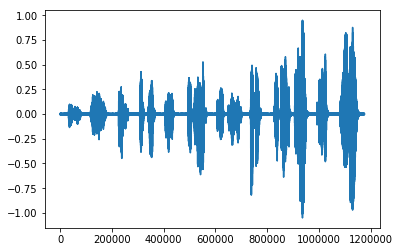

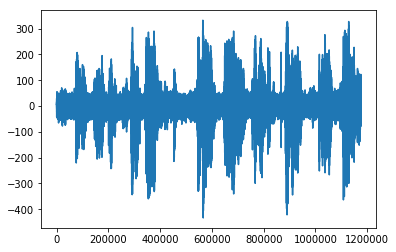

In [80]:
plotAudio(A1)
plotAudio(A2)

(b"ffmpeg version 3.3.4 Copyright (c) 2000-2017 the FFmpeg developers\n  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609\n  configuration: \n  libavutil      55. 58.100 / 55. 58.100\n  libavcodec     57. 89.100 / 57. 89.100\n  libavformat    57. 71.100 / 57. 71.100\n  libavdevice    57.  6.100 / 57.  6.100\n  libavfilter     6. 82.100 /  6. 82.100\n  libswscale      4.  6.100 /  4.  6.100\n  libswresample   2.  7.100 /  2.  7.100\nGuessed Channel Layout for Input Stream #0.0 : stereo\nInput #0, s16le, from 'pipe:':\n  Duration: N/A, bitrate: 1536 kb/s\n    Stream #0:0: Audio: pcm_s16le, 48000 Hz, stereo, s16, 1536 kb/s\nOutput #0, mov, to '../myFile.mov':\n  Metadata:\n    encoder         : Lavf57.71.100\n    Stream #0:0: Audio: pcm_s16le (sowt / 0x74776F73), 48000 Hz, stereo, s16, 1536 kb/s\nStream mapping:\n  Stream #0:0 -> #0:0 (copy)\nsize=    4594kB time=00:00:24.49 bitrate=1536.8kbits/s speed= 941x    \nvideo:0kB audio:4594kB subtitle:0kB other streams:0kB global he

In [70]:
#A2 , RA, OA = readAudio('../myFile.mp4',duration)

IPython.display.display(IPython.display.Audio(A, rate=48000))
#IPython.display.display(IPython.display.Audio(A2, rate=48000))

error: ushort format requires 0 <= number <= (32767 * 2 + 1)

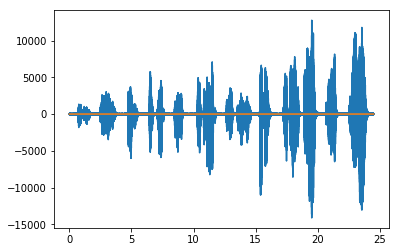

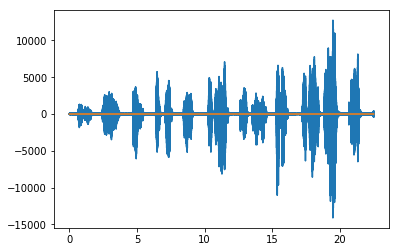

2352000


NameError: name 'sr' is not defined

In [17]:
plotAudio(A,48000)
plotAudio(A2,48000)
print(A.size)
print(sr)

0.000307614660353
2144.81351886


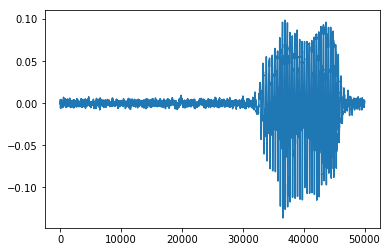

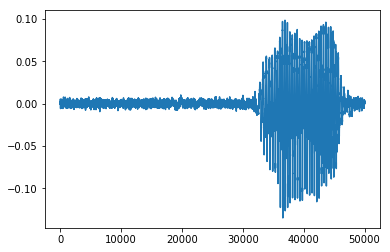

In [240]:
fa = np.fft.fft(A)

x = np.abs(fa)
print(x.min())
print(x.max())

fa[np.abs(fa) < 5]=0

out = np.fft.ifft(fa)
out = out.real
#fpass = np.zeros_like(fa)
#perc = 0.001
#n = fa.size
#cut = int(n*perc)
#fpass[cut+1:-cut]=1
#ff = fpass * fa
#out = np.fft.ifft(ff)
#out = out.real

plotAudio(A[0:50000])
plotAudio(out[0:50000])

#print(cut)
#print(A[:100])
#print(out[:100])

In [241]:
IPython.display.display(IPython.display.Audio(out[:100000], rate=sr))
IPython.display.display(IPython.display.Audio(A[:100000], rate=sr))

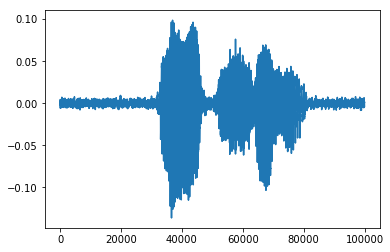

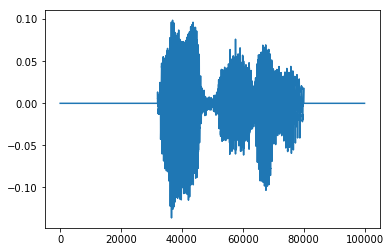

In [201]:
B = np.copy(A)
#block = 100
#tr = 0.00000000000000001
#for i in range(block, B.size, block):
#    if ( (B[i-block:i+block]<tr).all() ):
#        B[i-block:i+block]=0

#B[np.abs(B)<0.01]=0
B[:32000]=0
B[80000:100000]=0
plotAudio(A[0:100000])
plotAudio(B[0:100000])
#plotAudio(out[0:100000])
#print(np.abs(A).mean())
#print(B[:100])

In [202]:
IPython.display.display(IPython.display.Audio(B[:100000], rate=sr))
IPython.display.display(IPython.display.Audio(A[:100000], rate=sr))

In [148]:
V = np.arange(10)
if (V<10).all():
    print('1')
else :
    print('2')

1


In [ ]:
face_cascade = cv2.CascadeClassifier('/home/eu/anaconda3/pkgs/opencv3-3.1.0-py36_0/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml')
# eye_cascade = cv2.CascadeClassifier('/home/eu/anaconda3/pkgs/opencv3-3.1.0-py36_0/share/OpenCV/haarcascades/haarcascade_eye.xml')

#I = pmimg.imread('./Lenna.png')
#I = cv2.imread('./Lenna.png')
I = lastImg
#if (I.dtype.kind == 'f'):
#    I = (I * 255).astype(np.uint8)
    
#print('I:\n',I[:5,:5,0])
gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
gray = gray[100:,500:1400]
Ialt = I[100:,500:1400]
#plt.imshow(gray, cmap='gray')
#print('gray antes:\n',gray[:5,:5])
#gray = gray.astype(np.uint8)
#print('gray depois:\n',gray[:5,:5])
#plt.figure(1)
#plt.imshow(gray,cmap='gray')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)
(x,y,w,h) = faces[0]
roi_I = Ialt[y:y+h, x:x+w,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(Ialt)
plt.subplot(122)
plt.imshow(roi_I)


In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [ ]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [ ]:
%matplotlib inline
import scipy.misc
import numpy as np
import argparse
import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pmimg

#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,
#    help="path to facial landmark predictor")
#ap.add_argument("-i", "--image", required=True,
#    help="path to input image")
#args = vars(ap.parse_args())

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
#I = pmimg.imread('./Lenna.png')
#I = lastImg
Ialt = lastImg[100:,500:1400]
#Ialt = pmimg.imread('./Lenna.png')
Ir = scipy.misc.imresize(Ialt,(500,500))
plt.figure(2)
gray = cv2.cvtColor(Ir, cv2.COLOR_RGB2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#shape2 = predictor(gray, faces[0])
print('rec:', rects)
print('faces:', faces)
# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    print(shape.shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = rect_to_bb(rect)
    
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom();
    
    #cv2.rectangle(Ir, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cv2.rectangle(Ir, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # show the face number
    #cv2.putText(Ir, "Face #{}".format(i + 1), (x - 10, y - 10),
    #    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(Ir, (x, y), 1, (0, 0, 255), -1)

        
plt.figure(1)
#plt.subplot(121)
plt.imshow(Ir)
plt.axis('off')
#plt.subplot(122)
#plt.imshow(Ir)        

# show the output image with the face detections + facial landmarks
#cv2.imshow("Output", Ir)
#cv2.waitKey(0)